# EV State of Charge: Distribution of inital and final SoC

## Data Preparation

### Import Libraries

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

### Load the Dataset

In [29]:
# Replace 'path_to_file.xlsx' with the actual path to your Excel file
file_path = '../data/raw/epfl_session_data.xlsx'
data = pd.read_excel(file_path)

### Inspect the Dataset

In [30]:
# Display the first few rows to understand its structure
data.sample(5)

,Session,CCS,Arrival,Departure,Stay (min),Energy (Wh),Pmax (W),Preq_max (W),"Controlled session (0=False, 1=True)",TotalCapacity,BulkCapacity,SOC arrival,SOC departure,Energy capacity (Wh)
127,1658,CCS2,2023-03-31 19:24:00,2023-03-31 19:34:00,11,14835.0,106812,228708,1,10000,8000,22.0,46.99,56395.558223
545,801,CCS1,2023-04-01 17:36:00,2023-04-01 17:57:00,22,11301.0,57999,271632,1,10000,8000,86.0,99.00,82584.230769
32,917,CCS1,2023-05-08 13:02:00,2023-05-08 13:08:00,7,8315.0,94101,353265,1,10000,8000,53.0,63.00,78992.500000
1123,1373,CCS2,2022-10-20 09:43:00,2022-10-20 10:16:00,34,30731.0,72021,159210,0,10000,8000,37.0,80.00,67894.069767
496,706,CCS1,2023-03-14 21:16:00,2023-03-14 21:36:00,21,40527.0,156945,353265,1,10000,8000,6.0,58.00,74039.711538


In [31]:
# Ensure the date columns are in datetime format
data['Arrival'] = pd.to_datetime(data['Arrival'])
data['Departure'] = pd.to_datetime(data['Departure'])

# Find the earliest arrival and the latest departure
earliest_arrival = data['Arrival'].min()
latest_departure = data['Departure'].max()

print("Earliest arrival date:", earliest_arrival)
print("Latest departure date:", latest_departure)

Earliest arrival date: 2022-04-12 19:27:00
Latest departure date: 2023-07-04 23:48:00


### Preprocessing

In [32]:
# Step 4: Preprocessing
# Check for missing or invalid data in these columns
initial_soc_col = 'SOC arrival'
final_soc_col = 'SOC departure'

# Ensure the necessary columns exist in the dataset
if initial_soc_col in data.columns and final_soc_col in data.columns:
    # Drop rows with missing or invalid SOC values
    data = data[[initial_soc_col, final_soc_col]].dropna()

    # Remove outliers if applicable (e.g., SOC should be between 0 and 100)
    data = data[(data[initial_soc_col] >= 0) & (data[initial_soc_col] <= 100)]
    data = data[(data[final_soc_col] >= 0) & (data[final_soc_col] <= 100)]

    # Round SOC values to the nearest integer
    data[initial_soc_col] = data[initial_soc_col].round()
    data[final_soc_col] = data[final_soc_col].round()

else:
    raise ValueError(f"The dataset does not contain required columns '{initial_soc_col}' and '{final_soc_col}'")


## Plots of Distributions

### Initial SOC Distribution

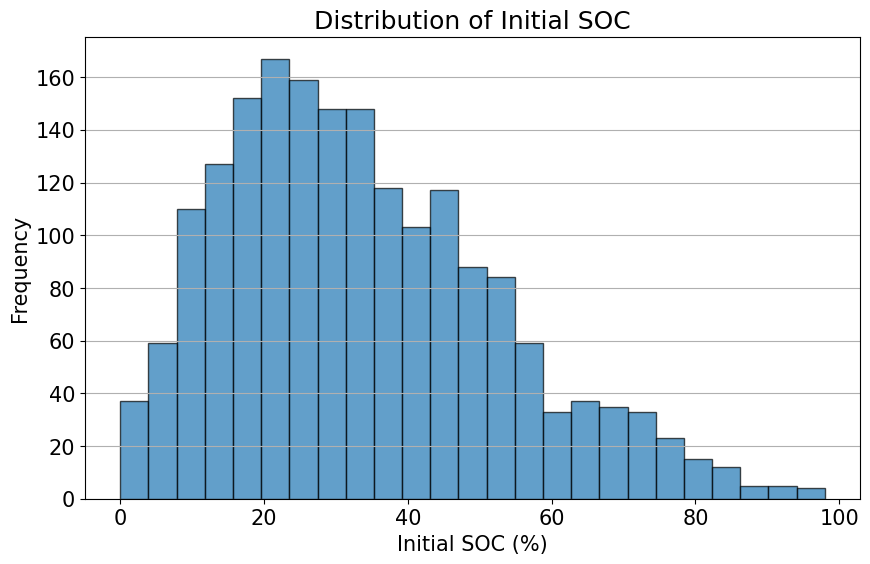

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(data[initial_soc_col], bins=25, alpha=0.7, edgecolor='black')
plt.title('Distribution of Initial SOC')
plt.xlabel('Initial SOC (%)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

### Final SOC Distribution

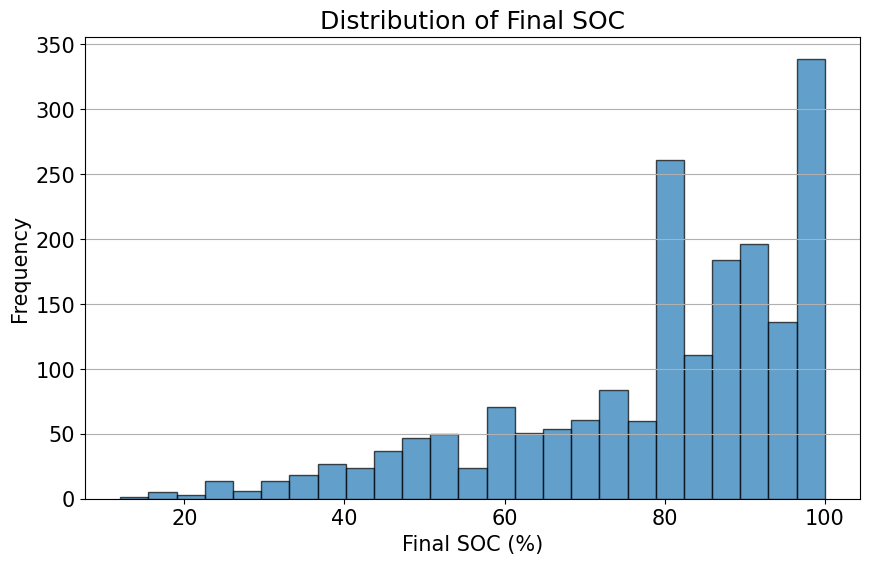

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(data[final_soc_col], bins=25, alpha=0.7, edgecolor='black')
plt.title('Distribution of Final SOC')
plt.xlabel('Final SOC (%)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

## Scatter plot of charge requests

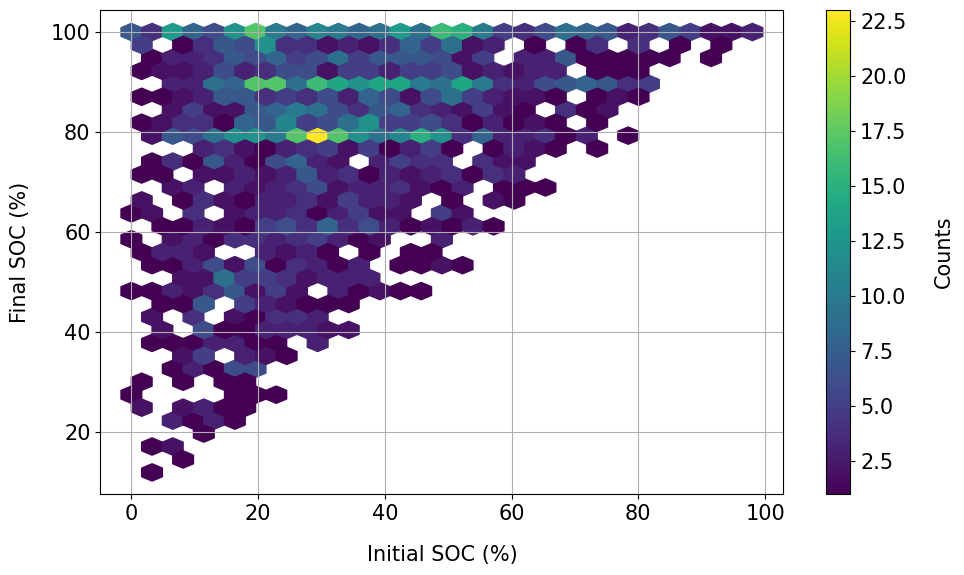

In [35]:
# Set global font size to 15
plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(10, 6))
hb = plt.hexbin(data[initial_soc_col], data[final_soc_col], gridsize=30, cmap='viridis', mincnt=1)
plt.xlabel('Initial SOC (%)', labelpad=15)
plt.ylabel('Final SOC (%)', labelpad=15)
cb = plt.colorbar(hb)
# Increase the distance between the "Counts" label and the colorbar by adjusting labelpad
cb.set_label('Counts', labelpad=20)
plt.grid(True)
plt.tight_layout()
plt.show()


## Bivariate Model Fitting: Keep coupling between initial and final SoC

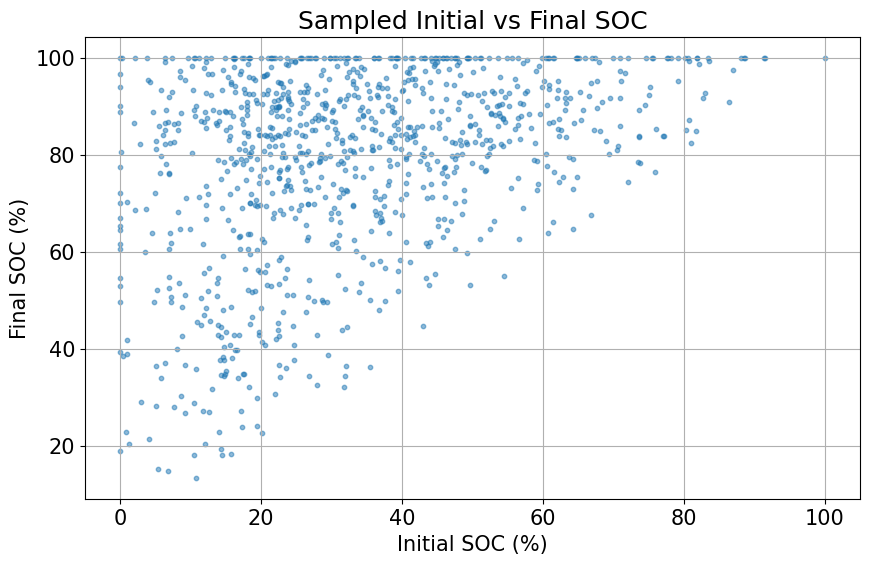

In [36]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Step 1: Extract Initial and Final SOC
initial_soc = data[initial_soc_col].values
final_soc = data[final_soc_col].values

# Combine into a 2D array (each row is a pair [initial_soc, final_soc])
paired_data = np.vstack([initial_soc, final_soc])

# Step 2: Fit a Multivariate KDE
kde = gaussian_kde(paired_data, bw_method='scott')  # 'scott' or 'silverman' for bandwidth

# Step 3: Sample from the KDE
num_samples = 1000
sampled_pairs = kde.resample(num_samples)  # Result is a 2D array: [initial_soc_samples, final_soc_samples]

# Convert to individual arrays for convenience
sampled_initial_soc = sampled_pairs[0]
sampled_final_soc = sampled_pairs[1]

# Step 4: Apply Logical Constraints (e.g., final_soc >= initial_soc)
# Optionally clamp values to valid ranges (0 to 100)
valid_samples = sampled_initial_soc <= sampled_final_soc
sampled_initial_soc = sampled_initial_soc[valid_samples]
sampled_final_soc = sampled_final_soc[valid_samples]

# Further clamp to the range [0, 100]
sampled_initial_soc = np.clip(sampled_initial_soc, 0, 100)
sampled_final_soc = np.clip(sampled_final_soc, 0, 100)

# Plot the joint distribution of sampled data
plt.figure(figsize=(10, 6))
plt.scatter(sampled_initial_soc, sampled_final_soc, alpha=0.5, s=10)
plt.title('Sampled Initial vs Final SOC')
plt.xlabel('Initial SOC (%)')
plt.ylabel('Final SOC (%)')
plt.grid(True)
plt.show()

In [37]:
import pickle

# Save the KDE model
with open('initial_final_soc_kde.pkl', 'wb') as file:
    pickle.dump(kde, file)

In [38]:
# Test it out
sampled_pairs = kde.resample(1)
sampled_initial_soc = sampled_pairs[0]
sampled_final_soc = sampled_pairs[1]

In [39]:
sampled_pairs[0][0]

np.float64(14.51119077598078)